# Localization

Use "localization" to learn a Cahn-Hilliard model.


## Learn a Cahn-Hilliard

Square domain periodic boundary conditions

## $$ \dot{\phi} = \nabla^2 \left( \phi^3 - \phi \right) - \gamma \nabla^4 \phi $$

## What are we trying to do?

Create a mapping from $t_0$ to $t_{10}$ without doing all the steps. We want to do the following.

## $$ \phi[s](t=t_0) \rightarrow \phi[s](t=t_{10})$$

## Localization

Use regression for each local state.

## Create Samples

In [4]:
%matplotlib inline

import pymks
import matplotlib.pyplot as plt
import numpy as np
from pymks.datasets import make_cahn_hilliard

In [5]:
n_steps = 10
size = (151, 151)
X, y = make_cahn_hilliard(n_samples=10, size=size, dt=1., n_steps=n_steps)

In [6]:
print(X.shape)
print(y.shape)

(10, 151, 151)
(10, 151, 151)


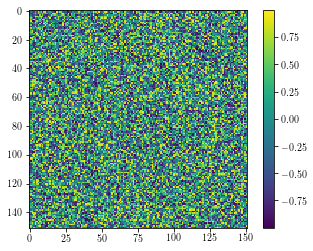

In [7]:
# NBVAL_IGNORE_OUTPUT

plt.imshow(X[0])
plt.colorbar()

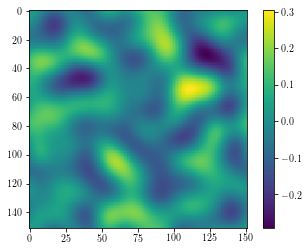

In [8]:
# NBVAL_IGNORE_OUTPUT

plt.imshow(y[0])
plt.colorbar()

## Parallel

In [9]:
from dask import compute, delayed
import dask.multiprocessing

def make_data(seed):
    np.random.seed(seed)
    return make_cahn_hilliard(n_samples=10, size=size, dt=1., n_steps=n_steps)

funcs = [delayed(make_data)(seed) for seed in range(30)]
    
out = compute(*funcs, get=dask.multiprocessing.get)


In [10]:
np.array(out).shape

(30, 2, 10, 151, 151)

In [11]:
X = np.array(out)[:, 0].reshape((300,) + size)
y = np.array(out)[:, 1].reshape((300,) + size)

## Learning

In [12]:
from pymks import MKSLocalizationModel
from pymks.bases import PrimitiveBasis

basis = PrimitiveBasis(n_states=5, domain=[-1, 1])
model = MKSLocalizationModel(basis=basis)

In [13]:
model.fit(X[:-1], y[:-1])

In [14]:
y_pred = model.predict(X[-1:])

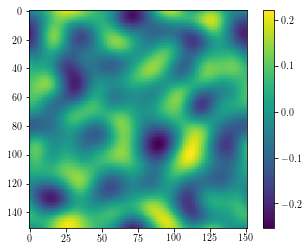

In [15]:
# NBVAL_IGNORE_OUTPUT
plt.imshow(y_pred[0])
plt.colorbar()

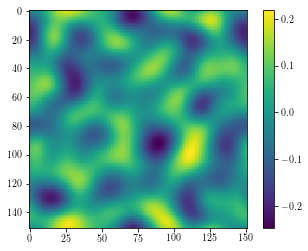

In [16]:
# NBVAL_IGNORE_OUTPUT
plt.imshow(y[-1])
plt.colorbar()

## Train Test Split

In [17]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [18]:
basis = PrimitiveBasis(n_states=5, domain=[-1, 1])
model = MKSLocalizationModel(basis=basis)

In [19]:
model.fit(X_train, y_train)

In [20]:
y_pred = model.predict(X_test)

In [21]:
# NBVAL_IGNORE_OUTPUT

metrics.mean_squared_error(y_pred.flatten(), y_test.flatten())

2.1555880393661474e-06

In [22]:
# NBVAL_IGNORE_OUTPUT

print(y_pred[0][0][:10])
print(y_test[0][0][:10])

[-0.00110223  0.0045004   0.01059271  0.01693907  0.0232881   0.02937962
  0.03495207  0.03975089  0.04353786  0.04610152]
[  9.93730853e-05   5.86033997e-03   1.21063191e-02   1.85983116e-02
   2.50806271e-02   3.12879128e-02   3.69529907e-02   4.18156644e-02
   4.56325562e-02   4.81878694e-02]


In [23]:
y_pred.shape

(75, 151, 151)

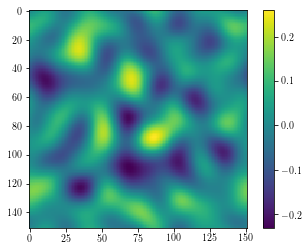

In [24]:
# NBVAL_IGNORE_OUTPUT

plt.imshow(y_pred[0])
plt.colorbar()

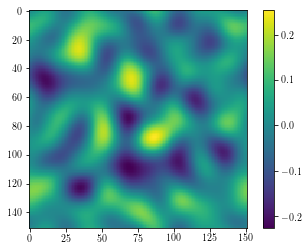

In [25]:
# NBVAL_IGNORE_OUTPUT

plt.imshow(y_test[0])
plt.colorbar()

## Scale Up

In [26]:
X_big, y_big = make_cahn_hilliard(n_samples=1, size=(1000, 1000), dt=1., n_steps=n_steps)

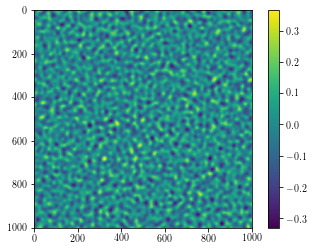

In [27]:
# NBVAL_IGNORE_OUTPUT

plt.imshow(y_big[0])
plt.colorbar()

In [28]:
basis = PrimitiveBasis(n_states=5, domain=[-1, 1])
model = MKSLocalizationModel(basis=basis)
model.fit(X, y)
model.resize_coeff(y_big[0].shape)

In [29]:
y_big_pred = model.predict(X_big)

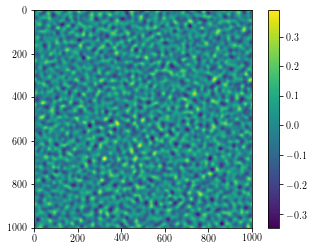

In [30]:
# NBVAL_IGNORE_OUTPUT

plt.imshow(y_big_pred[0])
plt.colorbar()

In [31]:
# NBVAL_IGNORE_OUTPUT

metrics.mean_squared_error(y_big_pred.flatten(), y_big.flatten())

2.1099181366034632e-06

In [32]:
# NBVAL_IGNORE_OUTPUT

%timeit make_cahn_hilliard(n_samples=1, size=(1000, 1000), dt=1., n_steps=n_steps)

2.53 s ± 29.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [33]:
# NBVAL_IGNORE_OUTPUT

%timeit model.predict(X_big)

218 ms ± 2.06 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Multiple Steps

In [34]:
X2, y2 = make_cahn_hilliard(n_samples=1, size=size, dt=1., n_steps=2 * n_steps)

basis = PrimitiveBasis(n_states=10, domain=[-1, 1])
model = MKSLocalizationModel(basis=basis)
model.fit(X, y)

In [35]:
tmp = model.predict(X2)
y2_pred = model.predict(tmp)

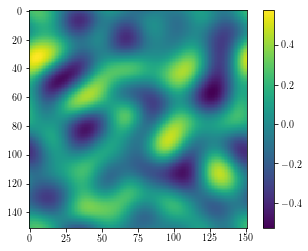

In [36]:
# NBVAL_IGNORE_OUTPUT

plt.imshow(y2[0])
plt.colorbar()

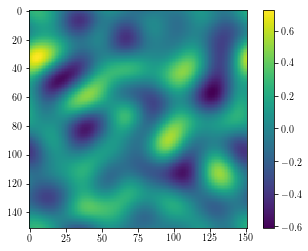

In [37]:
# NBVAL_IGNORE_OUTPUT

plt.imshow(y2_pred[0])
plt.colorbar()

In [38]:
# NBVAL_IGNORE_OUTPUT

metrics.mean_squared_error(y2_pred.flatten(), y2.flatten())

0.00031351700544175379

## Cross Validation

In [39]:
from pymks.bases import LegendreBasis
from sklearn.model_selection import GridSearchCV
from dask_searchcv import GridSearchCV
from sklearn import metrics
mse = metrics.mean_squared_error

prim_basis = PrimitiveBasis(2, [-1, 1])
leg_basis = LegendreBasis(2, [-1, 1])

params_to_tune = {'n_states': [2, 3, 5, 8, 13],
                  'basis': [prim_basis, leg_basis]}
model = MKSLocalizationModel(prim_basis)
score_func = metrics.make_scorer(lambda x, y: -mse(x.flatten(), y.flatten()))
gscv = GridSearchCV(model, params_to_tune, cv=5, scoring=score_func, scheduler="multiprocessing", n_jobs=8)

In [40]:
?GridSearchCV

In [41]:
# NBVAL_SKIP

gscv.fit(X_train, y_train)

GridSearchCV(cache_cv=True, cv=5, error_score='raise',
       estimator=MKSLocalizationModel(basis=<pymks.bases.primitive.PrimitiveBasis object at 0x7f97406b5908>,
           lstsq_rcond=2.2204460492503131e-12, n_jobs=None,
           n_states=array([0, 1])),
       iid=True, n_jobs=8,
       param_grid={'n_states': [2, 3, 5, 8, 13], 'basis': [<pymks.bases.primitive.PrimitiveBasis object at 0x7f97406b5908>, <pymks.bases.legendre.LegendreBasis object at 0x7f97406b5358>]},
       refit=True, return_train_score=True, scheduler='multiprocessing',
       scoring=make_scorer(<lambda>))

In [42]:
# NBVAL_SKIP

gscv.best_estimator_

MKSLocalizationModel(basis=<pymks.bases.legendre.LegendreBasis object at 0x7f97406b5b00>,
           lstsq_rcond=2.2204460492503131e-12, n_jobs=None, n_states=5)

In [43]:
# NBVAL_SKIP

gscv.score(X_test, y_test)

-1.0112404417022941e-06

In [44]:
# NBVAL_SKIP

gscv.cv_results_

{'mean_fit_time': array([ 16.07892206,  21.18541507,  30.1707891 ,  41.39256469,
         83.10909031,  15.81350434,  21.09269637,  33.81124536,
         49.81040086,  87.33250256]),
 'mean_score_time': array([  2.85809254,   4.15486318,   5.9808266 ,  13.8916885 ,
         13.74197972,   2.91444176,   4.15067057,   6.35742498,
         11.50110714,  12.87102915]),
 'mean_test_score': array([ -2.22335420e-05,  -2.23956097e-05,  -2.04233343e-06,
         -1.05399388e-06,  -9.84174560e-07,  -2.22335420e-05,
         -2.23846502e-05,  -9.25497479e-07,  -9.41153306e-07,
         -9.68875898e-07]),
 'mean_train_score': array([ -2.19804594e-05,  -2.18662070e-05,  -1.95267014e-06,
         -9.71922160e-07,  -8.57395059e-07,  -2.19804594e-05,
         -2.18599368e-05,  -8.85200210e-07,  -8.69587803e-07,
         -8.44952268e-07]),
 'param_basis': masked_array(data = [<pymks.bases.primitive.PrimitiveBasis object at 0x7f97406cc4e0>
              mask = [False False False False False False False 